In [1]:
# === 1) Imports & Params ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Optional

TRADING_DAYS_PER_MONTH = 21
GAMMA_FLOOR = 1e-6  # vega floor for stability in hedge ratio

# Paths (adjust if needed)
OPTIONS_PARQUET = "../../data/options_dataset.parquet"
OM_UNDERLYING_CSV = "../../data/OMunderlying.csv"

pd.set_option('display.width', 160)
pd.set_option('display.max_columns', 50)

In [2]:
df_1m = pd.read_csv('../FilteredDataset.csv', index_col=0)
df_1m['date'] = pd.to_datetime(df_1m['date'])
df_1m['exdate'] = pd.to_datetime(df_1m['exdate'])
print(f"\nFinal filtered dataset: {len(df_1m)} rows")
df_1m.head(10)
cols = ['date', 'exdate', 'cp_flag', 'strike_price', 'delta', 'vega', 'impl_volatility', 'gamma']

full_df = pd.read_parquet('../../data/options_dataset.parquet', columns=cols)


full_df['date'] = pd.to_datetime(full_df['date'])
full_df['exdate'] = pd.to_datetime(full_df['exdate'])
full_df['strike_price'] = full_df['strike_price'] / 1000.0  # adjust strike price
print(f"\nFull options dataset: {len(full_df)} rows")

df_1m = df_1m.merge(
    full_df,
    on=cols[:-1],
    how='left'
)

df_1m.head(10)


Final filtered dataset: 28073947 rows

Full options dataset: 36251366 rows


,date,exdate,cp_flag,strike_price,spot,moneyness,dte,mid,best_bid,best_offer,volume,open_interest,delta,vega,impl_volatility,spread,rel_spread,gamma
0,2000-01-03,2000-01-22,P,1275.0,1455.22,0.876156,19,2.0000,1.750,2.250,585,23785,-0.041295,28.57753,0.358787,0.500,0.250000,0.000763
1,2000-01-03,2000-01-22,P,1300.0,1455.22,0.893336,19,2.6250,2.250,3.000,3572,26621,-0.055490,36.20153,0.334738,0.750,0.285714,0.001036
2,2000-01-03,2000-01-22,P,1325.0,1455.22,0.910515,19,3.8125,3.500,4.125,1406,30757,-0.079749,47.92918,0.317378,0.625,0.163934,0.001446
3,2000-01-03,2000-01-22,C,1325.0,1455.22,0.910515,19,134.5000,133.500,135.500,315,29529,0.983012,13.61578,0.207545,2.000,0.014870,0.000628
4,2000-01-03,2000-01-22,C,1350.0,1455.22,0.927695,19,111.1250,110.125,112.125,112,20500,0.939732,38.63064,0.229941,2.000,0.017998,0.001609
5,2000-01-03,2000-01-22,P,1350.0,1455.22,0.927695,19,5.1875,4.875,5.500,819,24413,-0.109956,60.74824,0.294041,0.625,0.120482,0.001978
6,2000-01-03,2000-01-22,C,1375.0,1455.22,0.944874,19,88.5000,87.500,89.500,6,7885,0.884385,62.96457,0.229135,2.000,0.022599,0.002631
7,2000-01-03,2000-01-22,P,1375.0,1455.22,0.944874,19,6.9375,6.750,7.125,2633,18270,-0.150684,75.57642,0.267472,0.375,0.054054,0.002706
8,2000-01-03,2000-01-22,C,1380.0,1455.22,0.948310,19,84.0000,83.000,85.000,4,13,0.872528,67.43791,0.226489,2.000,0.023810,0.002851
9,2000-01-03,2000-01-22,P,1380.0,1455.22,0.948310,19,8.1250,7.625,8.625,69,1458,-0.168821,81.41239,0.271506,1.000,0.123077,0.002871


In [4]:
df_1m['gamma'].describe()

count    2.807395e+07
mean     1.080597e-03
std      1.633822e-03
min      0.000000e+00
25%      2.000000e-04
50%      5.730000e-04
75%      1.314000e-03
max      1.649940e-01
Name: gamma, dtype: float64

In [15]:
# === 5) Utilities (small, testable) ===
def choose_strike_for_m0(spot0: float, m0: float, available_strikes: np.ndarray) -> float:
    target = float(m0) * float(spot0)
    idx = np.abs(available_strikes - target).argmin()
    K = float(available_strikes[idx])
    return K

def nearest_atm_strike(spot0: float, available_strikes: np.ndarray) -> float:
    idx = np.abs(available_strikes - float(spot0)).argmin()
    K = float(available_strikes[idx])
    return K

def pick_one(day_df: pd.DataFrame, strike: float, cp_flag: str) -> Optional[pd.Series]:
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[pick_one] MISSING leg for cp={cp_flag}, K={strike}")
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','gamma','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[pick_one] All candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[pick_one] No clean candidate after filters for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

def fetch_next_row(next_df, strike, cp_flag):
    sub = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[next fetch] MISSING next-day row for cp={cp_flag}, K={strike}")
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','gamma','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[next fetch] All next-day candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[next fetch] No clean next-day candidate for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    return chosen

def half_spread(row: pd.Series) -> float:
    return float(max(0.0, (row['best_offer'] - row['best_bid']) / 2.0))

def pnl_from_price_change(qty: float, price_t: float, price_t1: float) -> float:
    return float(qty) * (float(price_t1) - float(price_t))

def self_financing_rebalance_cost(prev_qty: float, new_qty: float, half_spread_val: float) -> float:
    return abs(float(new_qty - prev_qty)) * float(half_spread_val)

In [8]:
# === 6A) Window builder ===
def get_window_dates(df_all: pd.DataFrame, start_idx: int) -> list[pd.Timestamp] | None:
    dates = np.sort(df_all['date'].unique())
    if start_idx + TRADING_DAYS_PER_MONTH >= len(dates):
        print(f"[get_window_dates] Not enough dates from start_idx={start_idx}.")
        return None
    days = list(dates[start_idx : start_idx + TRADING_DAYS_PER_MONTH + 1])

    return days

In [9]:
# === 6B) One day step ===
def one_day_step(df_all: pd.DataFrame,
                 d: pd.Timestamp, d_next: pd.Timestamp,
                 K_straddle: float, K_hedge: float,
                 phi_opt_prev: float, phi_under_prev: float) -> dict | None:
    day = df_all[df_all['date'] == d].copy()
    day_next = df_all[df_all['date'] == d_next].copy()
    if day.empty or day_next.empty:
        print(f="[one_day_step] Missing day data at {d} or {d_next}")
        return None

    row_C = pick_one(day, K_straddle, 'C')
    row_P = pick_one(day, K_straddle, 'P')
    row_H = pick_one(day, K_hedge, 'C')
    if row_H is None:
        row_H = pick_one(day, K_hedge, 'P')

    if (row_C is None) or (row_P is None) or (row_H is None):
        print("[one_day_step] Missing leg(s) at current day.")
        return None

    # Position greeks (straddle: long 1C + 1P)
    psi_C, psi_P = 1.0, 1.0
    V_t   = psi_C*row_C['mid'] + psi_P*row_P['mid']
    dV_t  = psi_C*row_C['delta'] + psi_P*row_P['delta']
    gV_t  = psi_C*row_C['gamma'] + psi_P*row_P['gamma']

    dH_t  = row_H['delta']
    gH_t  = row_H['gamma']

    vals = [V_t, dV_t, gV_t, dH_t, gH_t, row_H['mid']]
    if not all(np.isfinite(v) for v in vals):
        print(f"[one_day_step] Non-finite greeks/prices at {pd.Timestamp(d).date()} — abort window.")
        return None

    # Stabilize very small hedge gamma
    gH_eff = np.sign(gH_t) * max(abs(gH_t) if np.isfinite(gH_t) else 0.0, GAMMA_FLOOR)
    if not np.isfinite(gV_t):
        print(f"[one_day_step] Portfolio gamma NaN at {pd.Timestamp(d).date()} — abort window.")
        return None

    # Gamma hedge via option; residual delta via underlying
    phi_opt   = (gV_t / gH_eff) if not np.isclose(gH_eff, 0.0) else 0.0
    phi_under = dV_t - phi_opt * dH_t

    # Next-day marks
    row_C_next = fetch_next_row(day_next, row_C['strike_price'], 'C')
    row_P_next = fetch_next_row(day_next, row_P['strike_price'], 'P')
    row_H_next = fetch_next_row(day_next, row_H['strike_price'], row_H['cp_flag'])
    if (row_C_next is None) or (row_P_next is None) or (row_H_next is None):
        print("[one_day_step] Missing next-day leg(s).")
        return None

    s_t  = float(row_C['spot']);  s_t1 = float(row_C_next['spot'])
    hs_H = half_spread(row_H)

    pnl_opt    = pnl_from_price_change(phi_opt, row_H['mid'], row_H_next['mid'])
    pnl_under  = pnl_from_price_change(phi_under, s_t, s_t1)
    cost_opt   = self_financing_rebalance_cost(phi_opt_prev, phi_opt, hs_H)
    cost_under = 0.0  # same as before

    pnl_unhedged = (psi_C*(row_C_next['mid'] - row_C['mid']) +
                    psi_P*(row_P_next['mid'] - row_P['mid']))

    return dict(
        date=pd.Timestamp(d), spot=s_t,
        K_straddle=K_straddle, K_hedge=K_hedge,
        V_t=float(V_t), dV_t=float(dV_t), gV_t=float(gV_t),
        H_cp=row_H['cp_flag'], H_mid=float(row_H['mid']), dH_t=float(dH_t), gH_t=float(gH_t), gH_eff=float(gH_eff),
        phi_opt=float(phi_opt), phi_under=float(phi_under),
        cost_opt=float(cost_opt), cost_under=float(cost_under),
        pnl_opt=float(pnl_opt), pnl_under=float(pnl_under), pnl_unhedged=float(pnl_unhedged)
    )

In [17]:
# === 6C) Single window runner ===
def run_single_window(df_all: pd.DataFrame, start_idx: int, m0: float) -> dict | None:
    days = get_window_dates(df_all, start_idx)
    if days is None:
        return None
    d0 = pd.Timestamp(days[0])
    day0 = df_all[df_all['date'] == d0].copy()
    if day0.empty:
        print(f"[run_single_window] No rows on start day {d0}.")
        return None

    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    K_hedge    = nearest_atm_strike(spot0, strikes0)

    phi_opt_prev = 0.0; phi_under_prev = 0.0
    records = []; V0 = None; Pi_t = None

    for t in range(len(days)-1):
        d, d_next = pd.Timestamp(days[t]), pd.Timestamp(days[t+1])
        step = one_day_step(df_all, d, d_next, K_straddle, K_hedge, phi_opt_prev, phi_under_prev)
        if step is None:
            print("[run_single_window] Step failed; abort window.")
            return None

        if V0 is None:
            V0 = step['V_t']; Pi_t = V0; print(f"[init] V0=Π0={V0:.6f}")

        Pi_t1 = (Pi_t + step['pnl_opt'] + step['pnl_under'] - step['cost_opt'] - step['cost_under'])
        step['Pi_t'] = float(Pi_t); step['Pi_t1'] = float(Pi_t1)
        records.append(step)

        phi_opt_prev   = step['phi_opt']
        phi_under_prev = step['phi_under']
        Pi_t = Pi_t1

    # Final valuation
    last_day = pd.Timestamp(days[-2]); final_day = pd.Timestamp(days[-1])
    day_last  = df_all[df_all['date'] == last_day]
    day_final = df_all[df_all['date'] == final_day]

    row_C_last = pick_one(day_last, K_straddle, 'C');  row_C_fin = fetch_next_row(day_final, K_straddle, 'C')
    row_P_last = pick_one(day_last, K_straddle, 'P');  row_P_fin = fetch_next_row(day_final, K_straddle, 'P')
    if (row_C_last is None) or (row_P_last is None) or (row_C_fin is None) or (row_P_fin is None):
        print("[run_single_window] Final valuation missing legs.")
        return None

    V_T = float(row_C_fin['mid'] + row_P_fin['mid'])
    Pi_T = float(records[-1]['Pi_t1'])
    tracking_error = V_T - Pi_T
    pnl_unhedged_total = V_T - float(records[0]['V_t'])
    pnl_hedged_total   = Pi_T - float(records[0]['V_t'])

    timeline = pd.DataFrame(records).sort_values('date').reset_index(drop=True)
    summary = dict(
        start=days[0], end=days[-1], m0=float(m0),
        K_straddle=float(K_straddle), K_hedge=float(K_hedge),
        V0=float(records[0]['V_t']), V_T=float(V_T),
        Pi_T=float(Pi_T),
        tracking_error=float(tracking_error),
        pnl_unhedged=float(pnl_unhedged_total),
        pnl_hedged=float(pnl_hedged_total)
    )
    print(f"[window done] m0={m0}, Z_T={tracking_error:.6f}, V_T={V_T:.6f}, Π_T={Pi_T:.6f}")
    return dict(timeline=timeline, summary=summary)

In [11]:
# === 7) Multi-window experiment ===
def run_experiment_verbose(df_all: pd.DataFrame, m0_list: list[float], max_windows: int = 52, stop_on_fail: bool = False) -> pd.DataFrame:
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(0, len(dates) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
    start_indices = start_indices[:max_windows]
    results = []
    for m0 in m0_list:
        print(f"\n===== m0={m0} =====")
        for i, si in enumerate(start_indices, 1):
            print(f"\n--- Window {i}/{len(start_indices)} (start_idx={si}) ---")
            out = run_single_window(df_all, si, m0)
            if out is None:
                print(f"[run_experiment_verbose] Window failed for m0={m0}, start_idx={si}.")
                if stop_on_fail:
                    return pd.DataFrame(results)
                else:
                    continue
            results.append(out['summary'])
    return pd.DataFrame(results)

In [12]:
# === 8) Summaries ===
def summarize_results_verbose(results_df: pd.DataFrame) -> pd.DataFrame:
    if results_df is None or results_df.empty:
        print("[summarize_results_verbose] No results to summarize."); return pd.DataFrame()
    g = results_df.groupby('m0')
    out = g['tracking_error'].agg(['mean','median','std']).rename(columns={'std':'std_dev'})
    out['VaR_5pct']   = g['tracking_error'].quantile(0.05)
    out['VaR_2p5pct'] = g['tracking_error'].quantile(0.025)
    out['VaR_1pct']   = g['tracking_error'].quantile(0.01)
    return out

In [13]:
# === A) Backtest range: from 2021-01-01 to end ===
start_backtest = pd.Timestamp("2020-01-01")
df_1m_bt = df_1m[df_1m['date'] >= start_backtest].copy().sort_values('date')
print("Backtest:", df_1m_bt['date'].min().date(), "→", df_1m_bt['date'].max().date(), "| rows:", len(df_1m_bt))

dates_bt = np.sort(df_1m_bt['date'].unique())
start_indices_bt = list(range(0, len(dates_bt) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
max_windows_bt = len(start_indices_bt)
print("Candidate windows in range:", max_windows_bt)

Backtest: 2020-01-02 → 2023-08-31 | rows: 14429467
Candidate windows in range: 43


In [18]:
# === B/C) Run experiment ===
m0_list = [0.75, 0.8, 0.9, 1.1]
results_df = run_experiment_verbose(df_1m_bt, m0_list=m0_list, max_windows=max_windows_bt, stop_on_fail=False)
print("Results shape:", results_df.shape)
results_df.sort_values(['m0','end']).head(12)


===== m0=0.75 =====

--- Window 1/43 (start_idx=0) ---
[init] V0=Π0=812.150000
[next fetch] MISSING next-day row for cp=C, K=2445.0
[one_day_step] Missing next-day leg(s).
[run_single_window] Step failed; abort window.
[run_experiment_verbose] Window failed for m0=0.75, start_idx=0.

--- Window 2/43 (start_idx=21) ---
[init] V0=Π0=816.550000
[window done] m0=0.75, Z_T=9.540232, V_T=697.975000, Π_T=688.434768

--- Window 3/43 (start_idx=42) ---
[init] V0=Π0=782.775000
[window done] m0=0.75, Z_T=345.204727, V_T=298.350000, Π_T=-46.854727

--- Window 4/43 (start_idx=63) ---
[next fetch] MISSING next-day row for cp=P, K=1895.0
[one_day_step] Missing next-day leg(s).
[run_single_window] Step failed; abort window.
[run_experiment_verbose] Window failed for m0=0.75, start_idx=63.

--- Window 5/43 (start_idx=84) ---
[init] V0=Π0=709.725000
[window done] m0=0.75, Z_T=4.964318, V_T=988.850000, Π_T=983.885682

--- Window 6/43 (start_idx=105) ---
[init] V0=Π0=779.150000
[window done] m0=0.75, Z_T

,start,end,m0,K_straddle,K_hedge,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged
0,2020-02-03,2020-03-04,0.75,2435.0,3250.0,816.550,697.975,688.434768,9.540232,-118.575,-128.115232
1,2020-03-04,2020-04-02,0.75,2350.0,3130.0,782.775,298.350,-46.854727,345.204727,-484.425,-829.629727
2,2020-05-04,2020-06-03,0.75,2130.0,2845.0,709.725,988.850,983.885682,4.964318,279.125,274.160682
3,2020-06-03,2020-07-02,0.75,2340.0,3125.0,779.150,787.700,780.603895,7.096105,8.550,1.453895
4,2020-07-02,2020-08-03,0.75,2350.0,3130.0,779.175,944.225,940.653246,3.571754,165.050,161.478246
5,2020-08-03,2020-09-01,0.75,2470.0,3295.0,824.075,1052.475,1052.257168,0.217832,228.400,228.182168
6,2020-09-01,2020-10-01,0.75,2645.0,3525.0,878.500,734.250,740.531009,-6.281009,-144.250,-137.968991
7,2020-10-01,2020-10-30,0.75,2535.0,3380.0,865.200,760.900,764.611883,-3.711883,-104.300,-100.588117
8,2020-10-30,2020-12-01,0.75,2450.0,3270.0,821.300,1210.900,1201.313511,9.586489,389.600,380.013511
9,2020-12-01,2020-12-31,0.75,2745.0,3660.0,917.450,1022.850,1005.312272,17.537728,105.400,87.862272


In [19]:
# === D) Summary table ===
summary_tbl = summarize_results_verbose(results_df)
summary_tbl

,mean,median,std_dev,VaR_5pct,VaR_2p5pct,VaR_1pct
m0,,,,,,
0.75,11.911469,0.497917,57.995433,-8.940872,-10.439500,-16.570690
0.80,12.291195,3.246963,60.049072,-10.570507,-11.931006,-12.218277
0.90,16.718355,7.408289,40.237399,-8.420411,-10.233321,-17.849594
1.10,-9.005286,-8.282510,20.248333,-32.799450,-36.815145,-57.772421


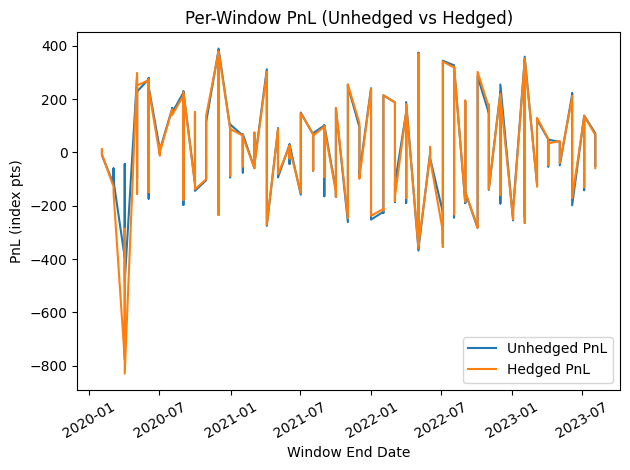

In [20]:
# === E) Plot: per-window PnL ===
res = results_df.sort_values('end').reset_index(drop=True).copy()
plt.figure()
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL')
plt.plot(res['end'], res['pnl_hedged'], label='Hedged PnL')
plt.title('Per-Window PnL (Unhedged vs Hedged)')
plt.xlabel('Window End Date'); plt.ylabel('PnL (index pts)'); plt.legend(); plt.xticks(rotation=30); plt.tight_layout(); plt.show()

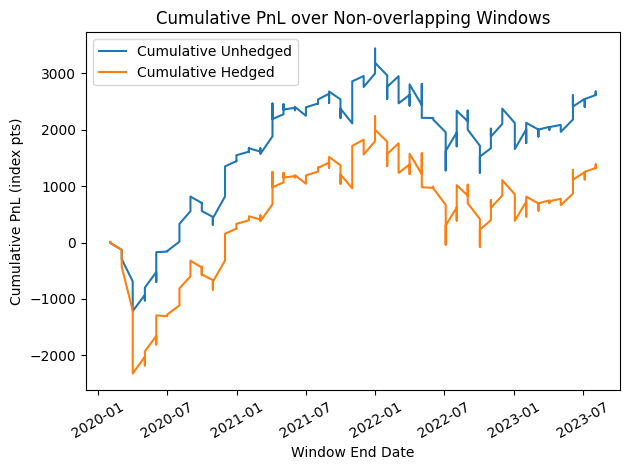

In [21]:
# === F) Plot: cumulative PnL ===
res = results_df.sort_values('end').reset_index(drop=True).copy()
res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged']   = res['pnl_hedged'].cumsum()
plt.figure()
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged')
plt.plot(res['end'], res['cum_hedged'], label='Cumulative Hedged')
plt.title('Cumulative PnL over Non-overlapping Windows')
plt.xlabel('Window End Date'); plt.ylabel('Cumulative PnL (index pts)'); plt.legend(); plt.xticks(rotation=30); plt.tight_layout(); plt.show()


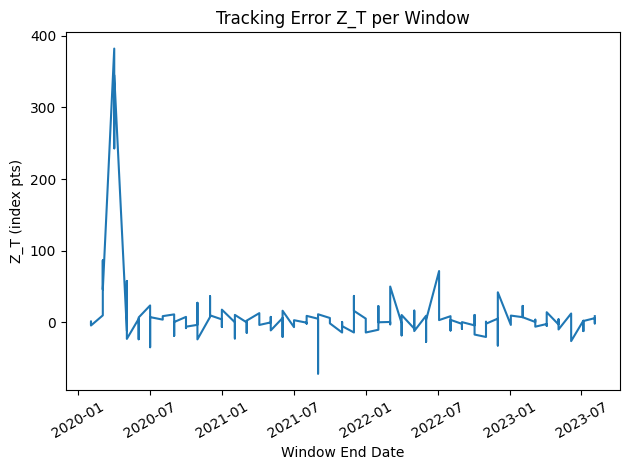

<Figure size 640x480 with 0 Axes>

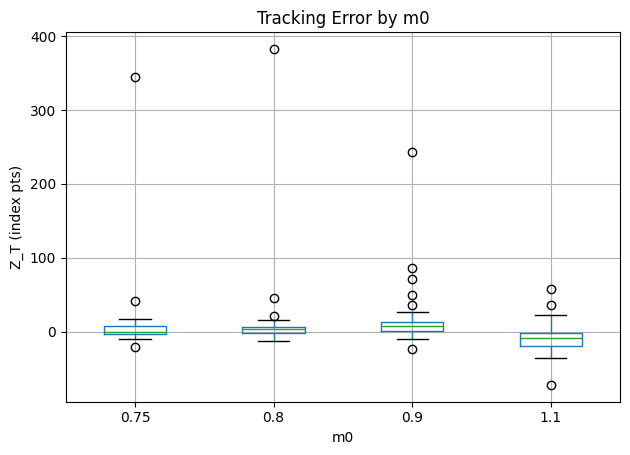

In [22]:
# === G) Plots: tracking error ===
res = results_df.sort_values('end').reset_index(drop=True).copy()
plt.figure()
plt.plot(res['end'], res['tracking_error'])
plt.title('Tracking Error Z_T per Window'); plt.xlabel('Window End Date'); plt.ylabel('Z_T (index pts)')
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

plt.figure()
results_df.boxplot(column='tracking_error', by='m0')
plt.title('Tracking Error by m0'); plt.suptitle(''); plt.xlabel('m0'); plt.ylabel('Z_T (index pts)')
plt.tight_layout(); plt.show()

In [23]:
# === Helper: get day-level timeline for a chosen results row ===
def get_timeline_for_row(df_slice, results, idx=0):
    row = results.iloc[idx]
    dates_arr = np.sort(df_slice['date'].unique())
    si = int(np.where(dates_arr == pd.Timestamp(row['start']))[0][0])
    out = run_single_window(df_slice, start_idx=si, m0=float(row['m0']))
    if out is None:
        raise RuntimeError("Window failed; check console logs for the failing day/leg.")
    return out['timeline'], out['summary']

# Example:
# tl, summ = get_timeline_for_row(df_1m_bt, results_df, idx=0)
# tl.head()

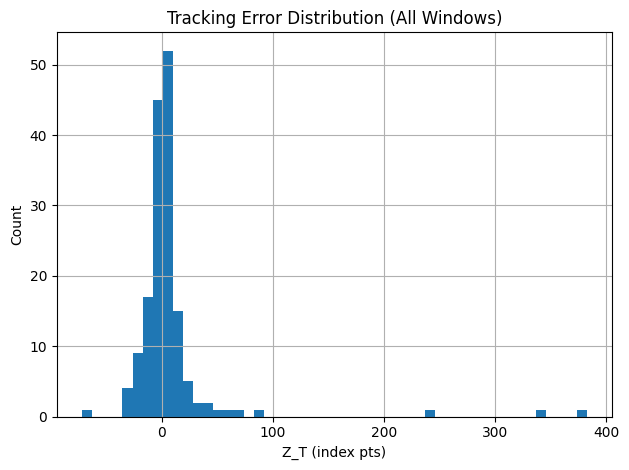

In [24]:
plt.figure()
results_df['tracking_error'].hist(bins=50)
plt.title('Tracking Error Distribution (All Windows)')
plt.xlabel('Z_T (index pts)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [25]:
# save to csv
results_df.to_csv('results_gamma.csv', index=False)
print("Delta results saved to results_gamma.csv")

Delta results saved to results_gamma.csv
